In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
import torch

%run "/code/source/notebooks/notebook_settings.py"
import source.config.config as config
import helpsk as hlp
import os
import pandas as pd

# MPG

In [2]:
with hlp.utility.Timer("Loading Data"):
    file_path = os.path.join(config.dir_data_raw(), 'auto_mpg.pkl')
    auto_mpg = pd.pandas.read_pickle(file_path)

Timer Started: Loading Data
Timer Finished (0.00 seconds)


In [3]:
hlp.pandas.numeric_summary(auto_mpg)

,# of Non-Nulls,# of Nulls,% Nulls,# of Zeros,% Zeros,Mean,St Dev.,Coef of Var,Skewness,Kurtosis,Min,10%,25%,50%,75%,90%,Max
MPG,398,0,0.0%,0,0.0%,23.5,7.8,0.3,0.5,-0.5,9.0,14.0,17.5,23.0,29.0,34.3,46.6
Cylinders,398,0,0.0%,0,0.0%,5.5,1.7,0.3,0.5,-1.4,3.0,4.0,4.0,4.0,8.0,8.0,8.0
Displacement,398,0,0.0%,0,0.0%,193.4,104.3,0.5,0.7,-0.8,68.0,90.0,104.2,148.5,262.0,350.0,455.0
Horsepower,392,6,2.0%,0,0.0%,104.5,38.5,0.4,1.1,0.7,46.0,67.0,75.0,93.5,126.0,157.7,230.0
Weight,398,0,0.0%,0,0.0%,"2,970.4",846.8,0.3,0.5,-0.8,"1,613.0","1,988.5","2,223.8","2,803.5","3,608.0","4,275.2","5,140.0"
Acceleration,398,0,0.0%,0,0.0%,15.6,2.8,0.2,0.3,0.4,8.0,12.0,13.8,15.5,17.2,19.0,24.8
Model Year,398,0,0.0%,0,0.0%,76.0,3.7,0.1,0.0,-1.2,70.0,71.0,73.0,76.0,79.0,81.0,82.0
Origin,398,0,0.0%,0,0.0%,1.6,0.8,0.5,0.9,-0.8,1.0,1.0,1.0,1.0,2.0,3.0,3.0


In [4]:
auto_mpg.dropna(inplace=True)
assert auto_mpg.isna().sum().sum() == 0

In [5]:
y_all = auto_mpg['MPG'].values
X_all = auto_mpg.drop(columns='MPG')

X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, train_size=0.8, random_state=1
)
assert len(X_train) + len(X_test) == len(X_all)
assert len(y_train) + len(y_test) == len(y_all)
assert len(X_train) == len(y_train)
assert len(X_test) == len(y_test)

In [6]:
numeric_column_names = [
    'Displacement',
    'Horsepower',
    'Weight',
    'Acceleration',
    'Model Year',
]
non_numeric_column_names = [
    'Cylinders',
    'Origin'
]

numeric_pipeline = make_pipeline(StandardScaler())
non_numeric_pipeline = make_pipeline(OneHotEncoder())

def to_tensor(x):
    return torch.from_numpy(x).float()

pipeline = make_pipeline(
    ColumnTransformer([
        ('numeric', numeric_pipeline, numeric_column_names),
        ('non_numeric', non_numeric_pipeline, non_numeric_column_names)
    ]),
    FunctionTransformer(func=to_tensor),
)

n_train = len(X_train)
n_test = len(X_test)
X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test)
assert n_train == len(X_train)
assert n_test == len(X_test)

y_train = to_tensor(y_train)
y_test = to_tensor(y_test)

In [7]:
import torch.nn as nn
from source.domain.pytorch_wrappers import FullyConnectedNN

network = FullyConnectedNN(
    input_size=X_train.shape[1],
    output_size=1,
    hidden_units=[8, 4],
    loss_func=nn.MSELoss(),
    learning_rate=0.001,
    early_stopping_delta=0.5,
    verbose=True
)

loss_hist_train, loss_hist_validation = network.train(
    X=X_train,
    y=y_train,
    batch_size=8,
    random_seed=2,
)

2022-12-04 23:31:09 - INFO     | Epoch 0: Training Loss=34.653; Validation Loss=38.207
2022-12-04 23:31:09 - INFO     | Validation loss decreased (inf --> 38.207298). Caching model state.
2022-12-04 23:31:09 - INFO     | Epoch 1: Training Loss=11.695; Validation Loss=12.750
2022-12-04 23:31:09 - INFO     | Validation loss decreased (38.207298 --> 12.749718). Caching model state.
2022-12-04 23:31:09 - INFO     | Epoch 2: Training Loss=9.457; Validation Loss=10.150
2022-12-04 23:31:09 - INFO     | Validation loss decreased (12.749718 --> 10.149647). Caching model state.
2022-12-04 23:31:09 - INFO     | Epoch 3: Training Loss=8.047; Validation Loss=8.000
2022-12-04 23:31:09 - INFO     | Validation loss decreased (10.149647 --> 8.000150). Caching model state.
2022-12-04 23:31:09 - INFO     | Epoch 4: Training Loss=10.529; Validation Loss=10.723
2022-12-04 23:31:09 - INFO     | Early Stopping counter: 1 out of 10
2022-12-04 23:31:09 - INFO     | Epoch 5: Training Loss=7.845; Validation Loss

In [8]:
network._early_stopping._index

15

Text(0.5, 0, 'Epochs')

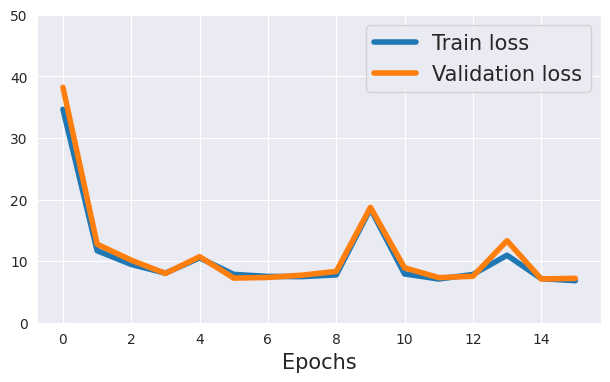

In [9]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 2, 1)
ax.set_ylim(0, 50)
plt.plot(loss_hist_train, lw=4)
plt.plot(loss_hist_validation, lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

In [10]:
test_pred = network.predict(X=X_test)
mse = nn.MSELoss()(test_pred, y_test).item()
print(f'Test MSE: {mse:.4f}')
print(f'Test MAE: {nn.L1Loss()(test_pred, y_test).item():.4f}')

Test MSE: 8.7097
Test MAE: 1.9749


---

# MNIST

In [11]:
import torchvision 
from torchvision import transforms 

image_path = './'
transform = transforms.Compose([transforms.ToTensor()])

mnist_train_dataset = torchvision.datasets.MNIST(
    root=image_path, 
    train=True, 
    # transform=transform, 
    download=True
)

mnist_test_dataset = torchvision.datasets.MNIST(
    root=image_path, 
    train=False, 
    #transform=transform, 
    download=False
)

assert isinstance(mnist_train_dataset, torch.utils.data.Dataset)
example = next(iter(mnist_train_dataset))
print(example)

/usr/local/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning:

Failed to load image Python extension: 



(<PIL.Image.Image image mode=L size=28x28 at 0xFFFF40BF0850>, 5)


In [12]:
mnist_train_dataset.data.shape

torch.Size([60000, 28, 28])

In [13]:
mnist_train_dataset.targets[0:10]

tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4])

In [14]:
mnist_train_dataset.classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

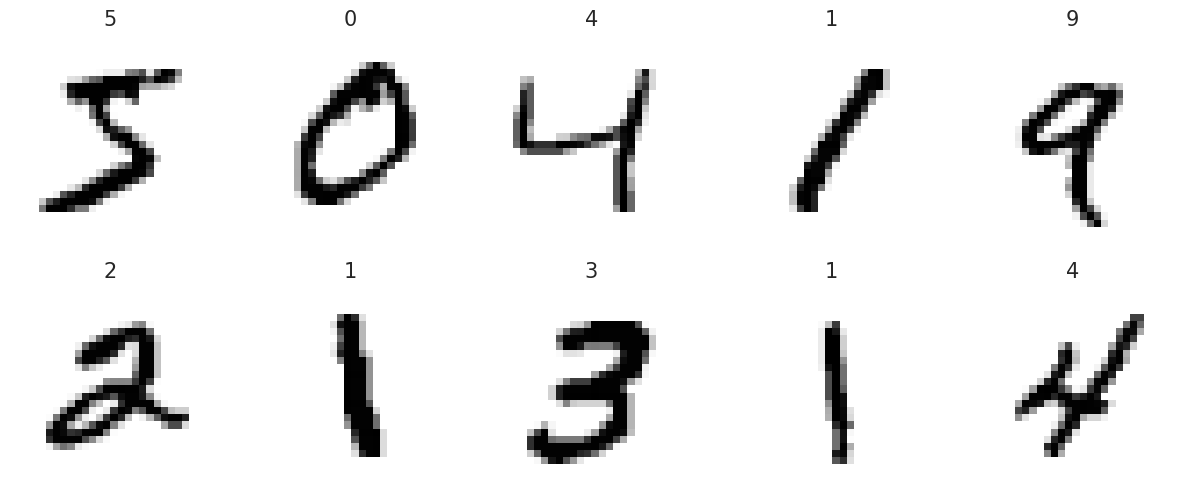

In [15]:
from itertools import islice

fig = plt.figure(figsize=(15, 6))
for i, (image, label) in islice(enumerate(mnist_train_dataset), 10):
    ax = fig.add_subplot(2, 5, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(image, cmap='gray_r')
    ax.set_title(f'{label}', size=15)
plt.show()

In [16]:
def to_tensor(x):
    return x.float()

pipeline = make_pipeline(
    FunctionTransformer(func=to_tensor),
)

n_train = len(mnist_train_dataset.data)
n_test = len(mnist_test_dataset.data)
X_train = pipeline.fit_transform(mnist_train_dataset.data)
X_test = pipeline.transform(mnist_test_dataset.data)
assert n_train == len(X_train)
assert n_test == len(X_test)

# y_train = to_tensor(mnist_train_dataset.targets)
# y_test = to_tensor(mnist_test_dataset.targets)
y_train = mnist_train_dataset.targets.long()
y_test = mnist_test_dataset.targets.long()

assert len(X_train) == len(y_train)
assert len(X_test) == len(y_test)

In [17]:
import torch.nn as nn
from source.domain.pytorch_wrappers import FullyConnectedNN

network = FullyConnectedNN(
    input_size=mnist_train_dataset.data.shape[1] * mnist_train_dataset.data.shape[2],
    output_size=10,
    hidden_units=[32, 16],
    loss_func=nn.CrossEntropyLoss(),
    optimizer_func=torch.optim.Adam,
    learning_rate=0.001,
    initial_layers=[nn.Flatten()],
    early_stopping_delta=0.005,
    verbose=True
)
network.layers

[Flatten(start_dim=1, end_dim=-1),
 Linear(in_features=784, out_features=32, bias=True),
 ReLU(),
 Linear(in_features=32, out_features=16, bias=True),
 ReLU(),
 Linear(in_features=16, out_features=10, bias=True)]

In [18]:
loss_hist_train, loss_hist_validation = network.train(
    X=X_train,
    y=y_train,
    batch_size=8,
    random_seed=2,
)

2022-12-04 23:31:16 - INFO     | Epoch 0: Training Loss=0.236; Validation Loss=0.263
2022-12-04 23:31:16 - INFO     | Validation loss decreased (inf --> 0.263176). Caching model state.
2022-12-04 23:31:20 - INFO     | Epoch 1: Training Loss=0.215; Validation Loss=0.254
2022-12-04 23:31:20 - INFO     | Validation loss decreased (0.263176 --> 0.254068). Caching model state.
2022-12-04 23:31:24 - INFO     | Epoch 2: Training Loss=0.213; Validation Loss=0.270
2022-12-04 23:31:24 - INFO     | Early Stopping counter: 1 out of 10
2022-12-04 23:31:28 - INFO     | Epoch 3: Training Loss=0.191; Validation Loss=0.245
2022-12-04 23:31:28 - INFO     | Validation loss decreased (0.254068 --> 0.244936). Caching model state.
2022-12-04 23:31:31 - INFO     | Epoch 4: Training Loss=0.155; Validation Loss=0.204
2022-12-04 23:31:31 - INFO     | Validation loss decreased (0.244936 --> 0.204227). Caching model state.
2022-12-04 23:31:35 - INFO     | Epoch 5: Training Loss=0.181; Validation Loss=0.244
2022-1

In [23]:
train_pred = network.predict(X=X_train)
is_correct = (torch.argmax(train_pred, dim=1) == y_train).float()
print(f'Traing accuracy: {is_correct.mean():.4f}') 

Traing accuracy: 0.9600


In [21]:
test_pred = network.predict(X=X_test)
is_correct = (torch.argmax(test_pred, dim=1) == y_test).float()
print(f'Test accuracy: {is_correct.mean():.4f}') 

Test accuracy: 0.9461


---

Text(0.5, 0, 'Epochs')

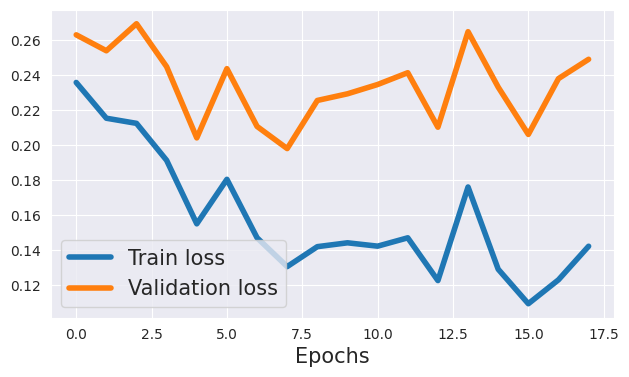

In [22]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 2, 1)
#ax.set_ylim(0, 50)
plt.plot(loss_hist_train, lw=4)
plt.plot(loss_hist_validation, lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)